In [92]:
import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd

import vpype_cli
from typing import List, Generic
from genpen import genpen as gp, utils as utils
from scipy import stats as ss
import geopandas
from shapely.errors import TopologicalError
import functools
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
page_x_inches: float = 11. # inches
page_y_inches: float = 8.5 # inches
border:float = 0.

buffer_style = 2

In [94]:
px = utils.DistanceConverter(page_x_inches, 'inches').mm
py = utils.DistanceConverter(page_y_inches, 'inches').mm
page_format = f'{px}mmx{py}mm'
drawbox = sg.box(border, border, px-border, py-border)

xmin, ymin, xmax, ymax = drawbox.bounds


In [146]:
p = gp.get_random_point_in_polygon(drawbox)

In [247]:
drawbox.bounds

(0.0, 0.0, 279.4, 215.89999999999998)

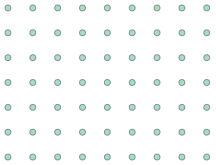

In [272]:
MultiPoint(start_points)

In [271]:
xcs, ycs = gp.overlay_grid(drawbox.buffer(-30), xstep=25, ystep=25)
start_points = [Point(x,y) for x,y in itertools.product(xcs, ycs)]

In [273]:
grams = []
for p in tqdm(start_points):
    width = 2
    height = 2
    sq = gp.centered_box(p, width=width, height=height)

    angle = np.random.uniform(360)
    sq = sa.rotate(sq, angle)
    trans_angle = np.random.uniform(np.pi*2)
    l = sq.boundary
    d_buffer = np.random.uniform(0.2, 0.4)
    d_translate = 0.1
    ls = []
    breakpoint=np.random.uniform(0, 0.6)
    for i in range(40):
        sl = so.substring(l, 0., breakpoint, normalized=True)
        jsl = gp.LineString_to_jittered_bezier(sl, n_midpoints=1, xstd=0.015, ystd=0.015, normalized=True)
        rsl = so.substring(l, breakpoint, 1, normalized=True)
        coords = list(jsl.coords) + list(rsl.coords)
        sq = Polygon(coords).buffer(d_buffer, cap_style=2, join_style=2)
        xoff = np.cos(trans_angle) * d_translate
        yoff = np.sin(trans_angle) * d_translate
        sq = sa.translate(sq, xoff=xoff, yoff=yoff)
        l = sq.boundary
        ls.append(l)
    gram = MultiLineString(ls)
    grams.append(gram)

100%|██████████| 63/63 [00:13<00:00,  4.58it/s]


In [274]:
layer = gp.merge_LineStrings(grams)

In [275]:
sk = vsketch.Vsketch()
sk.size(page_format)
sk.scale('1mm')
sk.penWidth('0.25mm')
sk.geometry(layer)
sk.display(color_mode='none')

<?xml version="1.0" encoding="utf-8" ?>
 
 
 
 
 image/svg+xml 
 
 2020-12-09T22:39:48.500328 
 
 
 
 
 
 <polygon points="136.7651,122.278 129.0769,127.2463 134.0439,134.9324 134.8097,134.4375 135.0731,134.2631 135.3315,134.084 135.5815,133.9024 135.8231,133.718 136.0564,133.531 136.2813,133.3412 136.4977,133.1485 136.7057,132.953 136.9051,132.7546 137.0959,132.5532 137.2781,132.3488 137.4516,132.1413 137.6162,131.9308 137.7719,131.7172 137.9186,131.5005 138.0562,131.2808 138.1845,131.0579 138.3035,130.8321 138.413,130.6033 138.5128,130.3717 138.603,130.1373 138.6834,129.9003 138.7539,129.6608 138.8145,129.4189 138.8651,129.1748 138.9056,128.9287 138.9361,128.6807 138.9566,128.431 138.967,128.1797 138.9675,127.9271 138.9581,127.6731 138.9389,127.418 138.9099,127.1618 138.8713,126.9046 138.8231,126.6465 138.7654,126.3875 138.6984,126.1277 138.6222,125.8671 138.5367,125.6057 138.4421,125.3435 138.3385,125.0805 138.226,124.8166 138.1046,124.5519 137.9743,124.2862 137.8353,124.0196 137.6875,123.7521 137.531,123.4835 137.3659,123.2139"/>
 <polygon points="137.0311,121.5555 136.0732,122.1694 135.7872,122.3607 135.5095,122.5545 135.2401,122.7511 134.979,122.9503 134.7264,123.1523 134.4821,123.3571 134.2463,123.5646 134.019,123.7751 133.8001,123.9884 133.5898,124.2046 133.388,124.4239 133.1949,124.646 133.0105,124.8712 132.8349,125.0994 132.6682,125.3307 132.5104,125.5649 132.3616,125.8021 132.2219,126.0424 132.0914,126.2855 131.9701,126.5316 131.8582,126.7805 131.7558,127.0321 131.6629,127.2865 131.5795,127.5434 131.5057,127.8027 131.4417,128.0645 131.3873,128.3285 131.3426,128.5946 131.3077,128.8627 131.2824,129.1327 131.2669,129.4045 131.261,129.678 131.2648,129.9531 131.2781,130.2296 131.3009,130.5076 131.3331,130.7869 131.3748,131.0675 131.4257,131.3493 131.4859,131.6324 131.5553,131.9167 131.6337,132.2021 131.7212,132.4888 131.8177,132.7766 131.9231,133.0656 132.0374,133.3558 132.1605,133.6472 132.2924,133.9398 132.4511,134.2716 133.8332,136.4102 135.2713,135.4809 135.5455,135.2994 135.8182,135.1104 136.0828,134.918 136.3395,134.7222 136.5881,134.5229 136.8286,134.3199 137.061,134.1131 137.285,133.9024 137.5008,133.6878 137.708,133.4691 137.9067,133.2462 138.0965,133.0191 138.2775,132.7877 138.4493,132.5521 138.6117,132.3121 138.7646,132.0678 138.9077,131.8193 139.0408,131.5667 139.1637,131.31 139.276,131.0495 139.3777,130.7853 139.4684,130.5178 139.5481,130.2471 139.6166,129.9735 139.6738,129.6974 139.7196,129.4191 139.7541,129.1389 139.7772,128.8571 139.7889,128.5741 139.7895,128.2902 139.7789,128.0055 139.7575,127.7204 139.7252,127.435 139.6823,127.1495 139.629,126.864 139.5655,126.5787 139.492,126.2935 139.4086,126.0086 139.3155,125.724 139.213,125.4396 139.1011,125.1555 138.98,124.8715 138.8498,124.5877 138.7106,124.3039 138.5626,124.0201 138.4058,123.7363 138.2403,123.4522 138.0662,123.168"/>
 <polygon points="137.1463,120.5978 136.2273,121.6795 136.0062,121.9496 135.7915,122.2219 135.5832,122.4965 135.3815,122.7733 135.1862,123.0524 134.9974,123.3337 134.8151,123.6172 134.6394,123.903 134.4702,124.191 134.3076,124.4812 134.1515,124.7735 134.0021,125.0681 133.8593,125.3648 133.7231,125.6637 133.5936,125.9647 133.4708,126.2678 133.3546,126.573 133.2451,126.8803 133.1423,127.1897 133.0462,127.5011 132.9569,127.8145 132.8742,128.1298 132.7983,128.4472 132.7291,128.7665 132.6666,129.0877 132.6109,129.4108 132.5619,129.7357 132.5196,130.0625 132.484,130.3912 132.4552,130.7216 132.433,131.0538 132.4176,131.3878 132.4088,131.7236 132.4067,132.0611 132.4113,132.4003 132.4225,132.7412 132.4404,133.0838 132.4649,133.4281 132.4961,133.774 132.5338,134.1216 132.5782,134.4709 132.6291,134.8218 132.6866,135.1743 132.7506,135.5285 132.8212,135.8843 132.8983,136.2417 132.9819,136.6008 133.1025,137.0835 133.6224,137.8881 135.7329,136.5243 136.0179,136.3356 136.3048,136.1367 136.5842,135.9337 136.8558,135.7265 137.1198,135.5148 137.376,135.2986 137.6242,135.0776 137.8644,134.8518 138.0964,134.621 138.3201,134.3849 138.5352,134.1436 138.741

In [276]:
savepath = '/mnt/c/code/side/plotter_images/oned_outputs/0103_substring_jitter.svg'

sk.save(savepath)

In [277]:
vpype_commands = 'reloop linesimplify --tolerance 0.01mm linemerge --tolerance 0.1mm reloop linesort'
vpype_str = f'vpype read -q 0.05mm {savepath} {vpype_commands} write {savepath}'

os.system(vpype_str)

0

In [225]:
p = drawbox.centroid
width = 20
height = 20
c = gp.centered_box(p, width=width, height=height)
c = sa.rotate(c, angle=np.random.uniform(360))
l = c.boundary
ls = []


In [230]:
sl.type

'LineString'

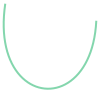

In [227]:
sl = so.substring(l, 0., breakpoint, normalized=True)
jsl = gp.LineString_to_jittered_bezier(sl, n_midpoints=2, xstd=0.001, ystd=0.002, normalized=True)
jsl

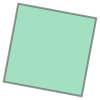

In [226]:
rsl = so.substring(l, breakpoint, 1, normalized=True)

In [223]:

d_buffer = 0.25
d_translate=0.15
breakpoint = np.random.uniform(0.15,0.85)
angle = np.random.uniform(0, np.pi*2)
for i in range(1):
    sl = so.substring(l, 0., breakpoint, normalized=True)
    jsl = gp.LineString_to_jittered_bezier(sl, n_midpoints=2, xstd=0.001, ystd=0.002, normalized=True)
    rsl = so.substring(l, breakpoint, 1, normalized=True)
    coords = list(jsl.coords) + list(rsl.coords)
    c = Polygon(coords).buffer(d_buffer, cap_style=2, join_style=2)
    xoff = np.cos(angle) * d_translate
    yoff = np.sin(angle) * d_translate
    c = sa.translate(c, xoff=xoff, yoff=yoff)
    l = c.boundary
    ls.append(l)
layer = MultiLineString(ls)

In [224]:
sk = vsketch.Vsketch()
sk.size(page_format)
sk.scale('1mm')
sk.penWidth('0.25mm')
sk.geometry(layer)
sk.display(color_mode='none')

<?xml version="1.0" encoding="utf-8" ?>
 
 
 
 
 image/svg+xml 
 
 2020-12-09T21:45:23.501342 
 
 
 
 
 
 <polygon points="524.5181,445.5014 562.1315,388.8154 558.2924,385.5133 555.089,382.9965 551.9091,380.7285 548.7579,378.7036 545.6402,376.9163 542.5612,375.3608 539.526,374.0315 536.5396,372.9229 533.6072,372.0296 530.7339,371.3459 527.9252,370.8665 525.1863,370.5859 522.5227,370.4986 519.9399,370.5992 517.4435,370.8822 515.0392,371.3421 512.7328,371.9732 510.5303,372.7698 508.4375,373.7262 506.4605,374.8362 504.6051,376.0939 502.8774,377.4931 501.2833,379.0272 499.8287,380.6898 498.5191,382.4743 497.3603,384.3741 496.3577,386.3822 495.5165,388.492 494.8421,390.6967 494.3393,392.9896 494.0132,395.3639 493.8685,397.8132 493.91,400.3308 494.1425,402.9103 494.5705,405.5455 495.1987,408.23 496.0317,410.9578 497.0742,413.7227 498.3309,416.5188 499.8065,419.3401 501.5057,422.1807 503.4333,425.0348 505.5941,427.8965 507.9929,430.76 510.6347,433.6196 513.5245,436.4694 516.667,439.3037 520.0674,442.1167"/>

In [281]:
ls = LineString([(50,50), (50, 10)])

In [289]:
jls = gp.LineString_to_jittered_bezier(ls, n_midpoints=15, xbias=0., xstd=0.03, ybias=0., ystd=0., normalized=True, n_eval_points=50)

In [293]:
n_points = len(jls.coords)

In [284]:
gp.gaussian_random_walk(100, )

array([1.        , 0.9997608 , 1.00646276, 1.00106411, 1.00660527,
       1.01761595, 1.02858745, 1.04501752, 1.03872291, 1.04331606,
       1.05465408, 1.04402199, 1.05340011, 1.06299216, 1.06606865,
       1.04879726, 1.03598647, 1.04972622, 1.04092581, 1.033739  ,
       1.05319239, 1.041402  , 1.04333061, 1.06007615, 1.06781735,
       1.06128183, 1.05540822, 1.04464622, 1.05801065, 1.05254447,
       1.05744155, 1.05025476, 1.04150961, 1.04356169, 1.03945882,
       1.0457075 , 1.04907484, 1.05255678, 1.05317276, 1.04983507,
       1.05464056, 1.04926272, 1.0411463 , 1.03369733, 1.03820628,
       1.0380335 , 1.04617486, 1.04785831, 1.05775799, 1.0633229 ,
       1.05120082, 1.0560133 , 1.03162109, 1.0246236 , 1.02410787,
       1.02484405, 1.01124912, 0.99676091, 0.99254023, 0.97749426,
       0.97578869, 0.96874456, 0.98742399, 0.98944014, 0.99273547,
       0.99077868, 0.98943245, 0.98991461, 0.9992501 , 0.99982183,
       0.99269825, 0.9782212 , 0.98564917, 0.9822827 , 0.99214

In [ ]:
curve1 = bezier.Curve(np.asfortranarray(jitter_ls).T, degree=n_midpoints+1)
bez = curve1.evaluate_multi(np.linspace(0., 1., n_eval_points))
sg.asLineString(bez.T)